In [1]:
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
import discorpy.losa.loadersaver as losa
import discorpy.prep.preprocessing as prep
import discorpy.proc.processing as proc
import discorpy.post.postprocessing as post
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import skimage as ski
import cv2
import multiprocessing as mp

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
instrument = "/HFIR/CG1D"
ipts="25781"
###################### need to change end

In [3]:
data_loc = instrument + "/IPTS-"+ipts+"/raw/alignment_calibration/2025_09_16_grid/"
sorted(os.listdir(data_loc))

['grid_0000_0015.tiff',
 'grid_0000_0016.tiff',
 'grid_0000_0017.tiff',
 'grid_0000_0018.tiff',
 'grid_0000_0019.tiff',
 'grid_0000_0020.tiff',
 'grid_0000_0021.tiff',
 'grid_0000_0022.tiff',
 'grid_0000_0023.tiff',
 'grid_0001_0014.tiff',
 'grid_0002_0013.tiff']

In [4]:
# Initial parameters
data_name = "grid_0000_0023"
data_path = data_loc + data_name + ".tiff"
num_coef = 5  # Number of polynomial coefficients
mat0 = losa.load_image(data_path) # Load image

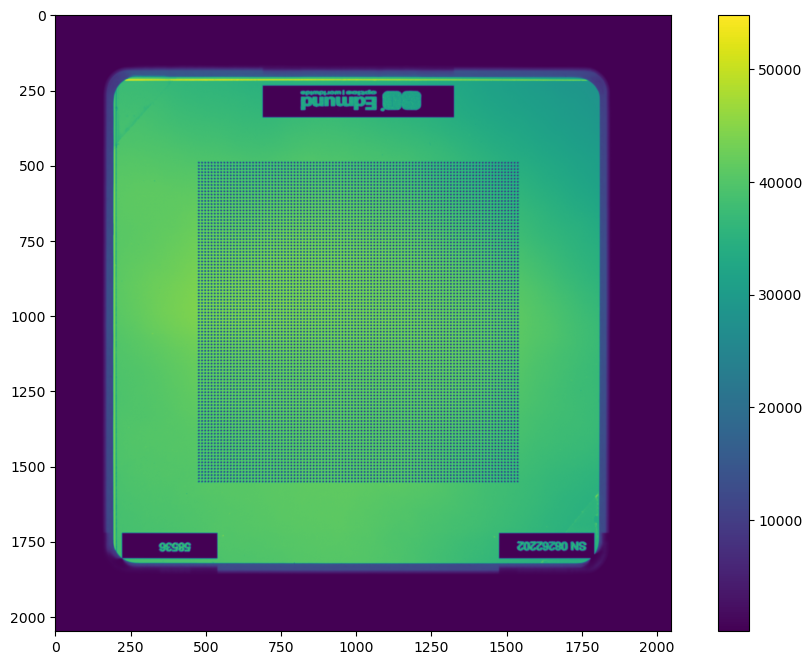

In [5]:
plt.imshow(mat0)
plt.colorbar()
plt.show()

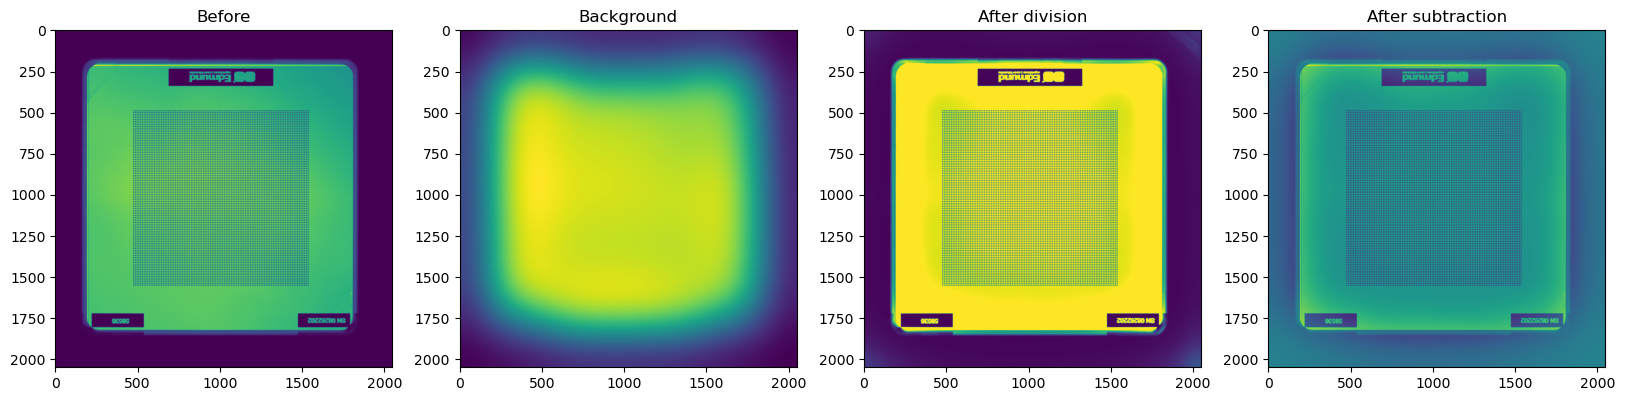

In [6]:
# crop = True
crop = False
crop_left = 300#320
crop_right = 1650#1080
crop_top = 400
crop_bottom = 1650
# rmv_bkg = False
rmv_bkg = True
###################### need to change end
mat_crop = rocku.crop(mat0, crop_left, crop_right, crop_top, crop_bottom, crop)
if rmv_bkg:
    # bkgd = ski.filters.gaussian(mat_crop, sigma=200, truncate=4)
    bkgd = cv2.GaussianBlur(mat_crop, (1001, 1001), 0)
    img_bg_div = mat_crop/bkgd
    img_bg_sub = mat_crop-bkgd
    # img_bg_sub = img_bg_sub*(1/img_bg_sub.max())
    f, ax = plt.subplots(1, 4, figsize=(20, 9))
    ax[0].imshow(mat_crop)#, vmax=0.2, vmin=0)
    ax[0].set_title('Before')
    ax[1].imshow(bkgd)#, vmax=0.2, vmin=0)
    ax[1].set_title('Background')
    ax[2].imshow(img_bg_div, vmax=1.2, vmin=0)
    ax[2].set_title('After division')
    ax[3].imshow(img_bg_sub, )#vmax=1.2, vmin=0)
    ax[3].set_title('After subtraction')
else:
    f, ax = plt.subplots(1, 1, figsize=(20, 9))
    ax.imshow(mat_crop)#, vmax=0.2, vmin=0)
    ax.set_title('Before')


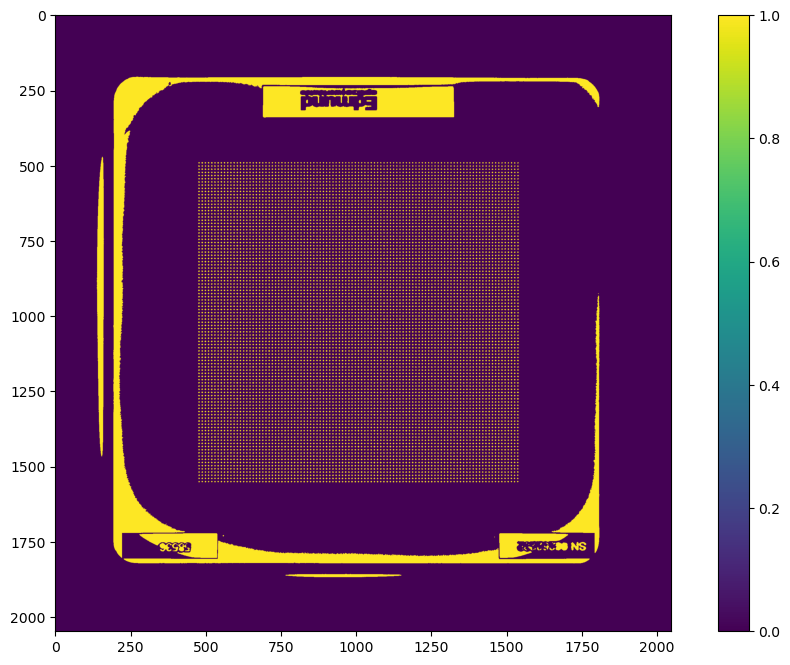

In [7]:
# Segment dots
# mat1 = prep.binarization(mat_crop)
mat1 = prep.binarization(img_bg_sub)
# mat1 = prep.binarization(img_bg_div)

plt.imshow(mat1)
plt.colorbar()
plt.show()

Horizontal slope: 0.00018819064707878015. Vertical slope -0.00013025576152691517


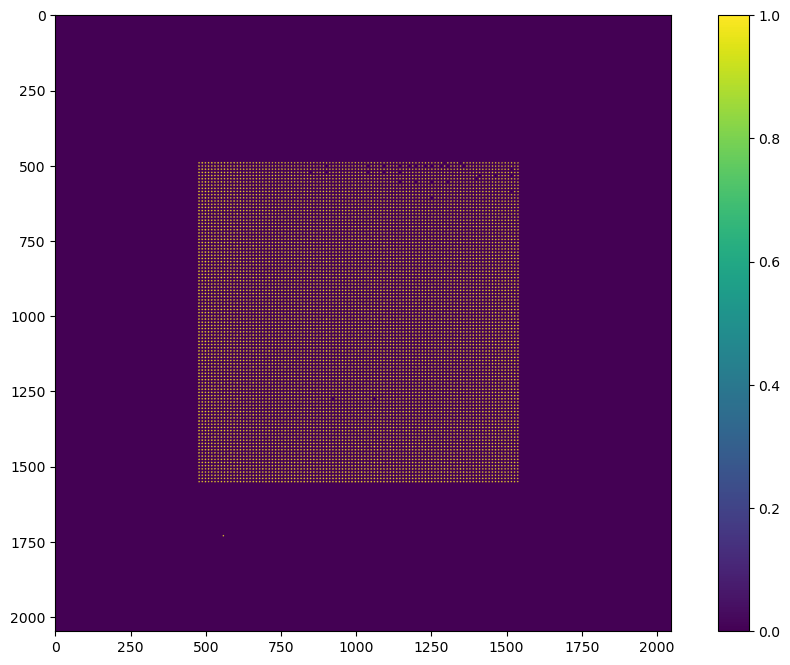

In [27]:
# Segment dots
# mat1 = prep.binarization(mat0)
# Calculate the median dot size and distance between them.
(dot_size, dot_dist) = prep.calc_size_distance(mat1)
# Remove non-dot objects
mat1 = prep.select_dots_based_size(mat1, dot_size)
# Remove non-elliptical objects
mat1 = prep.select_dots_based_ratio(mat1)
# losa.save_image(output_base + "/segmented_dots.jpg", mat1) # Save image for checking
# Calculate the slopes of horizontal lines and vertical lines.
hor_slope = prep.calc_hor_slope(mat1)
ver_slope = prep.calc_ver_slope(mat1)
print("Horizontal slope: {0}. Vertical slope {1}".format(hor_slope, ver_slope))
plt.imshow(mat1)
plt.colorbar()
plt.show()

In [28]:
(height, width) = mat1.shape
# Group points to horizontal lines
list_hor_lines = prep.group_dots_hor_lines(mat1, hor_slope, dot_dist)
# Group points to vertical lines
list_ver_lines = prep.group_dots_ver_lines(mat1, ver_slope, dot_dist)
# Optional: remove horizontal outliers
list_hor_lines = prep.remove_residual_dots_hor(list_hor_lines, hor_slope)
# Optional: remove vertical outliers
list_ver_lines = prep.remove_residual_dots_ver(list_ver_lines, ver_slope)

Text(0.5, 1.0, 'Reference-points (center-of-mass of dots) after grouped into #vertical# lines')

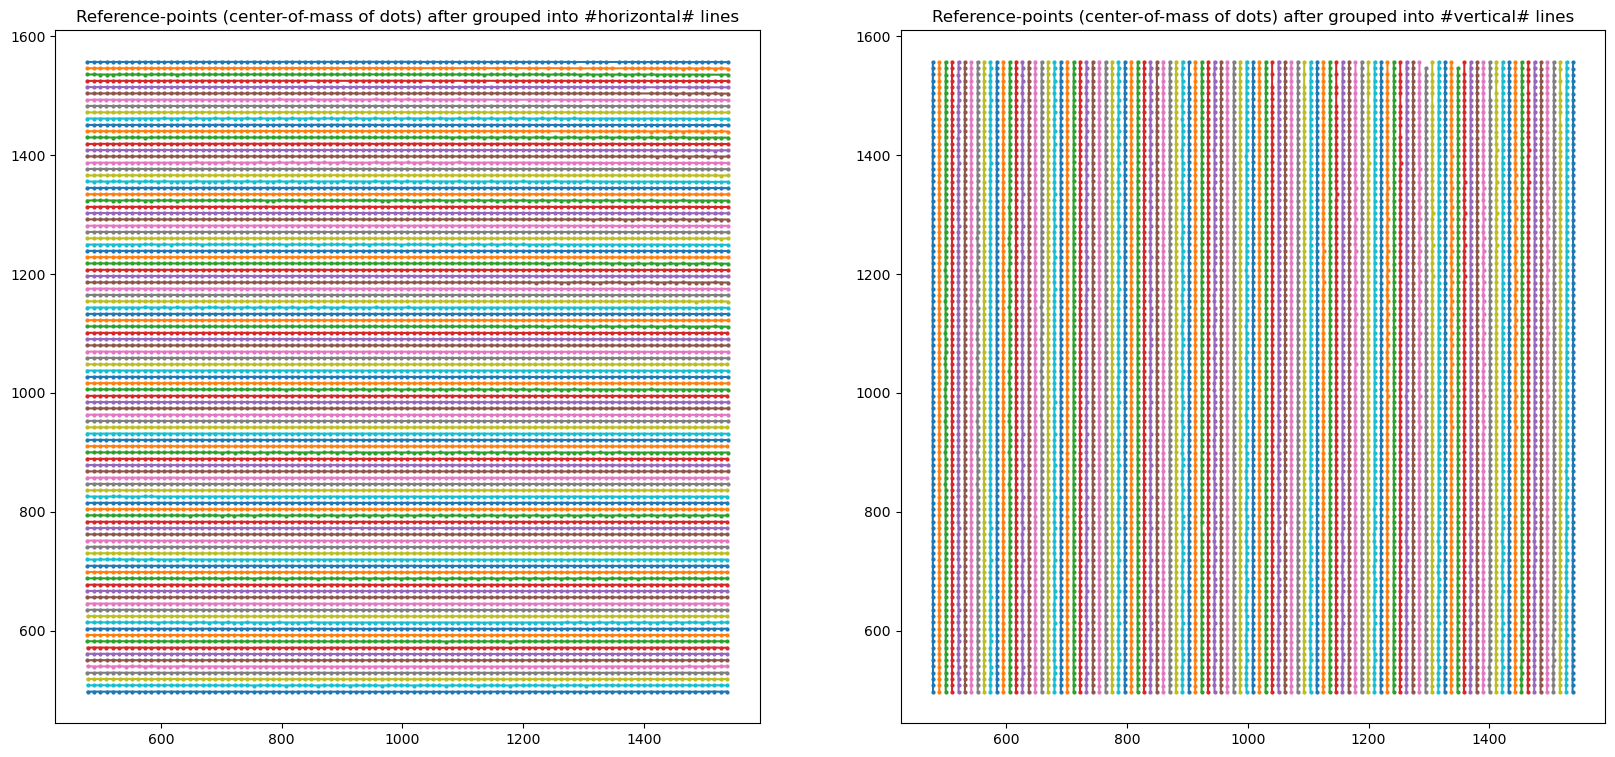

In [29]:
# Save output for checking
f, ax = plt.subplots(1, 2, figsize=(20, 9))
m_size = 2
for line in list_hor_lines:
    ax[0].plot(line[:, 1], height - line[:, 0], '-o', markersize=m_size)
for line in list_ver_lines:
    ax[1].plot(line[:, 1], height - line[:, 0], '-o', markersize=m_size)

# ax[0].set_xlim(0, width)
# ax[0].set_ylim(0, height)
# ax[1].set_xlim(0, width)
# ax[1].set_ylim(0, height)
ax[0].set_title('Reference-points (center-of-mass of dots) after grouped into #horizontal# lines')
ax[1].set_title('Reference-points (center-of-mass of dots) after grouped into #vertical# lines')

Text(0.5, 1.0, 'Distances of the dot-centroids from their fitted straight line against their distances\n from the axes origin for #vertical# lines')

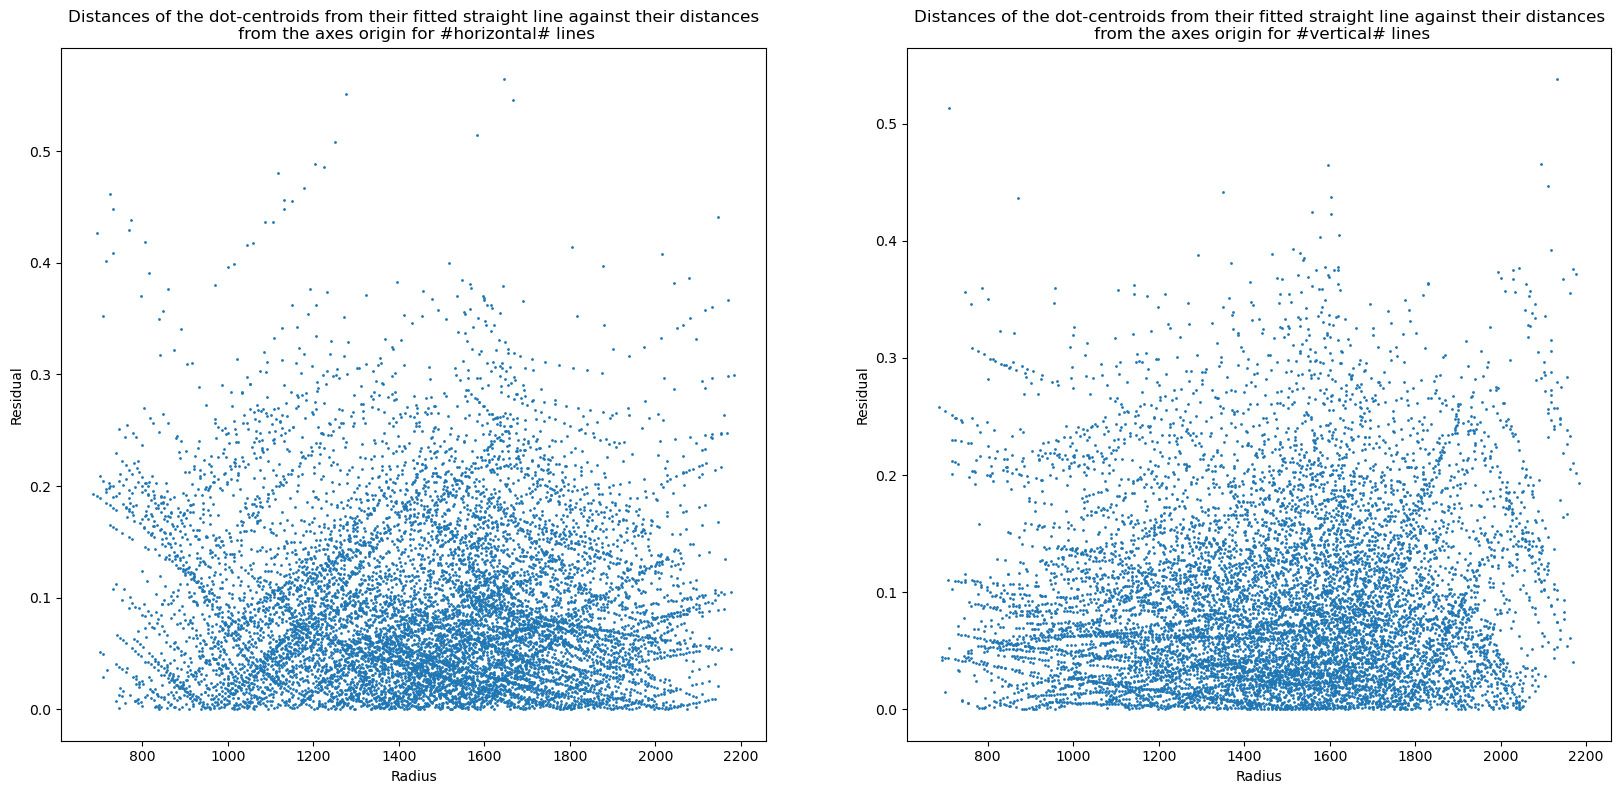

In [30]:
list_hor_data = post.calc_residual_hor(list_hor_lines, 0.0, 0.0)
list_ver_data = post.calc_residual_ver(list_ver_lines, 0.0, 0.0)
f, ax = plt.subplots(1, 2, figsize=(20, 9))
m_size = 2
ax[0].plot(list_hor_data[:, 0], list_hor_data[:, 1], '.', markersize=m_size)
ax[0].set_ylabel("Residual")
ax[0].set_xlabel("Radius")
ax[1].plot(list_ver_data[:, 0], list_ver_data[:, 1], '.', markersize=m_size)
ax[1].set_ylabel("Residual")
ax[1].set_xlabel("Radius")

ax[0].set_title('Distances of the dot-centroids from their fitted straight line against their distances\n from the axes origin for #horizontal# lines')
ax[1].set_title('Distances of the dot-centroids from their fitted straight line against their distances\n from the axes origin for #vertical# lines')

 

In [31]:
# Calculate the center of distortion
(xcenter, ycenter) = proc.find_cod_coarse(list_hor_lines, list_ver_lines)
# Calculate coefficients of the correction model
list_fact = proc.calc_coef_backward(list_hor_lines, list_ver_lines,
                                    xcenter, ycenter, num_coef)
# Save the results for later use.
# losa.save_metadata_txt(output_base + "/coefficients_radial_distortion.txt",
#                      xcenter, ycenter, list_fact)
print("X-center: {0}. Y-center: {1}".format(xcenter, ycenter))
print("Coefficients: {0}".format(list_fact))

X-center: 833.4346510468157. Y-center: 973.3056595553097
Coefficients: [ 1.00066830e+00 -2.03150527e-05  6.33136396e-08 -8.82505711e-11
  4.28989939e-14]


In [32]:
# Apply correction to the lines of points
list_uhor_lines = post.unwarp_line_backward(list_hor_lines, xcenter, ycenter,
                                            list_fact)
list_uver_lines = post.unwarp_line_backward(list_ver_lines, xcenter, ycenter,
                                            list_fact)

Text(0.5, 1.0, 'Unwarpped #vertical# lines')

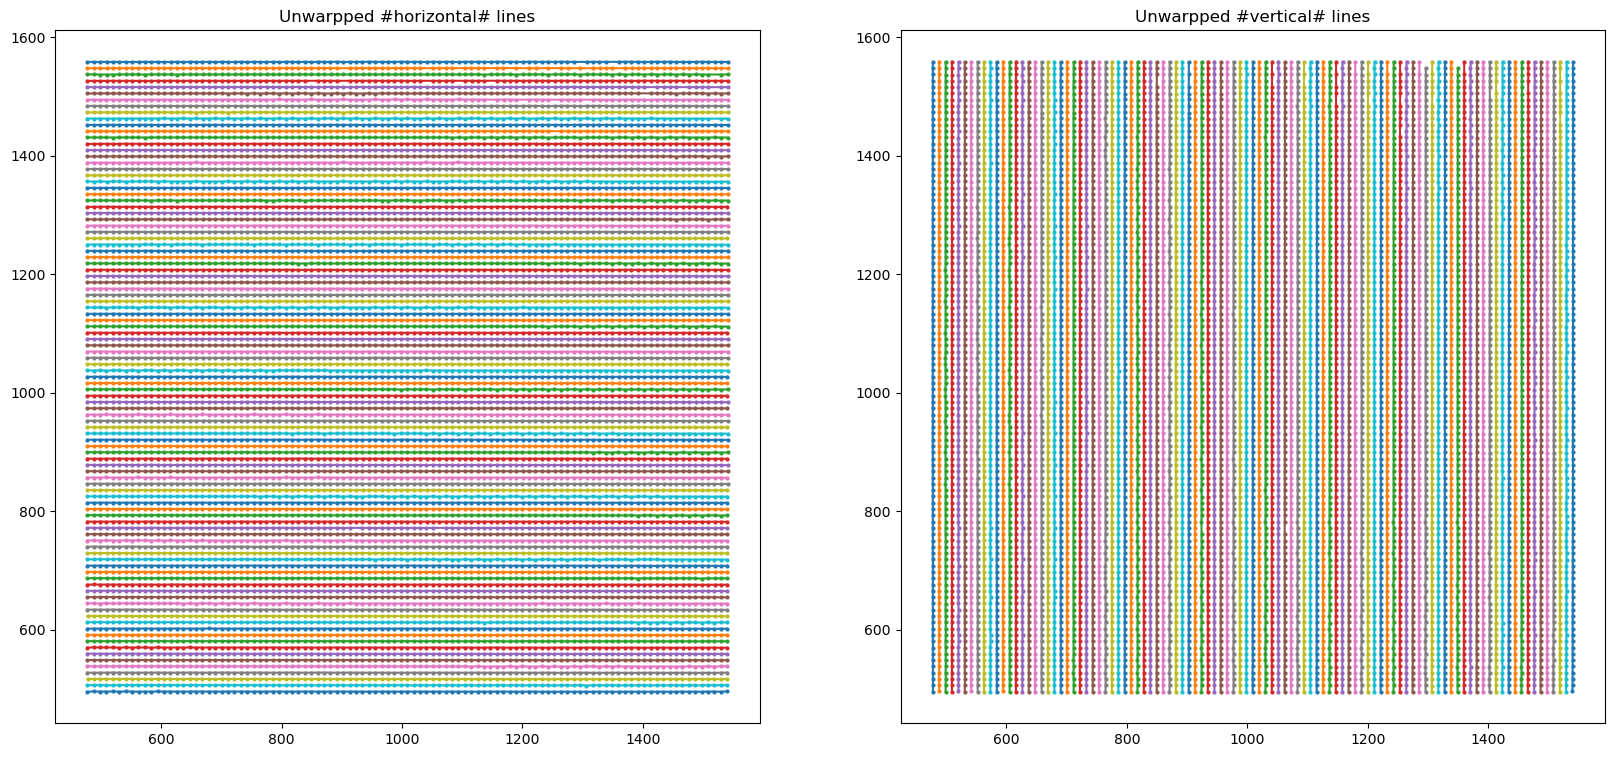

In [33]:
# Save the results for checking
f, ax = plt.subplots(1, 2, figsize=(20, 9))
m_size = 2
for line in list_uhor_lines:
    ax[0].plot(line[:, 1], height - line[:, 0], '-o', markersize=m_size)
for line in list_uver_lines:
    ax[1].plot(line[:, 1], height - line[:, 0], '-o', markersize=m_size)
# ax[0].set_xlim(0, width)
# ax[0].set_ylim(0, height)
# ax[1].set_xlim(0, width)
# ax[1].set_ylim(0, height)
ax[0].set_title('Unwarpped #horizontal# lines')
ax[1].set_title('Unwarpped #vertical# lines')

Text(0.5, 1.0, 'Residual of the unwarpped points #vertical#')

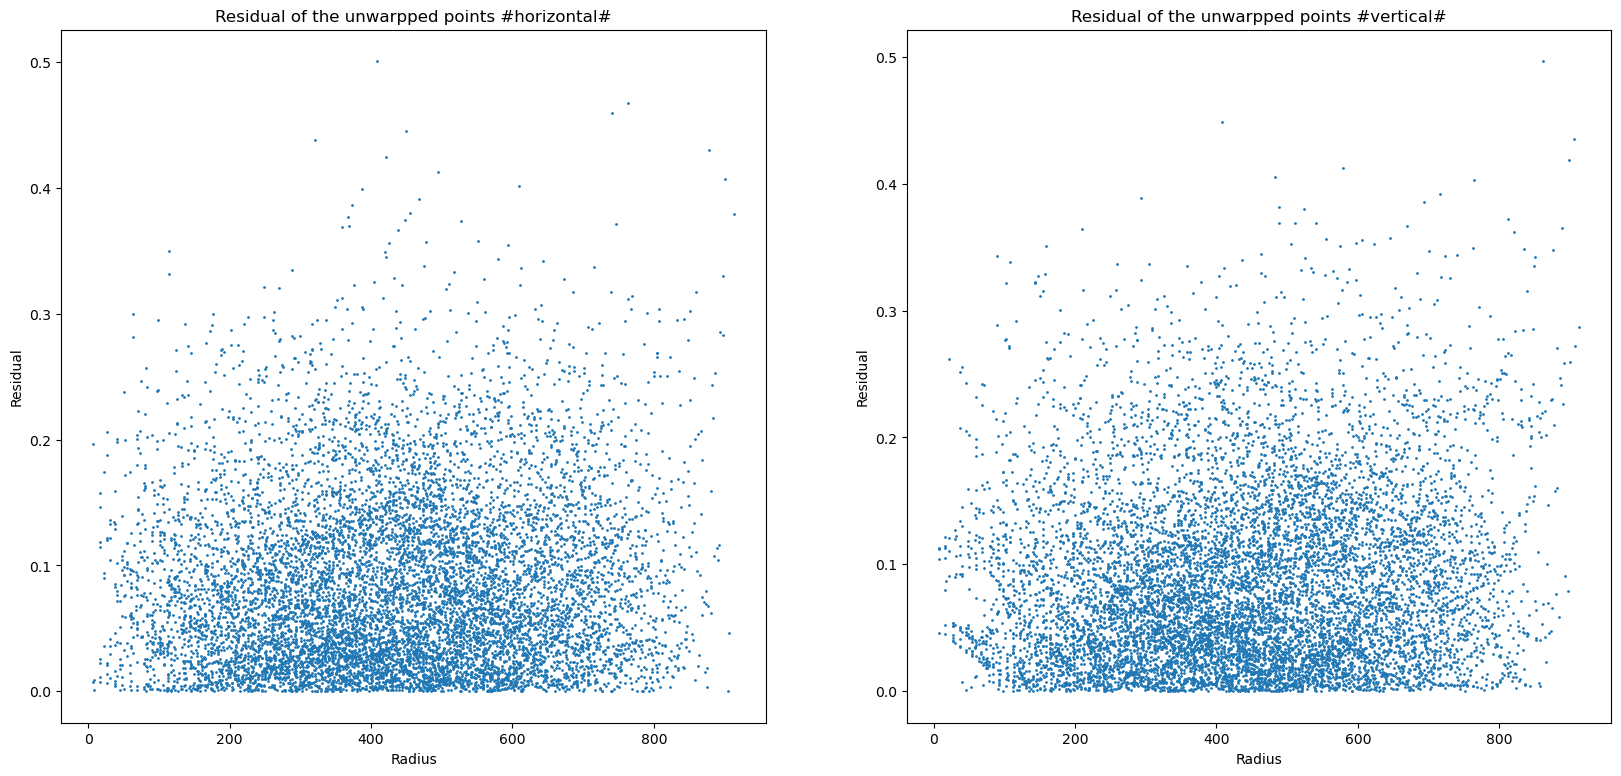

In [34]:
# Calculate the residual of the unwarpped points.
list_uhor_data = post.calc_residual_hor(list_uhor_lines, xcenter, ycenter)
list_uver_data = post.calc_residual_ver(list_uver_lines, xcenter, ycenter)
# Save the results for checking
f, ax = plt.subplots(1, 2, figsize=(20, 9))
m_size = 2
ax[0].plot(list_uhor_data[:, 0], list_uhor_data[:, 1], '.', markersize=m_size)
ax[0].set_ylabel("Residual")
ax[0].set_xlabel("Radius")
ax[1].plot(list_uver_data[:, 0], list_uver_data[:, 1], '.', markersize=m_size)
ax[1].set_ylabel("Residual")
ax[1].set_xlabel("Radius")
#Residual of the unwarpped points. Note that the origin of the coordinate system is at the center of distortion
ax[0].set_title('Residual of the unwarpped points #horizontal#')
ax[1].set_title('Residual of the unwarpped points #vertical#')

Text(0.5, 1.0, 'Difference (subtraction)')

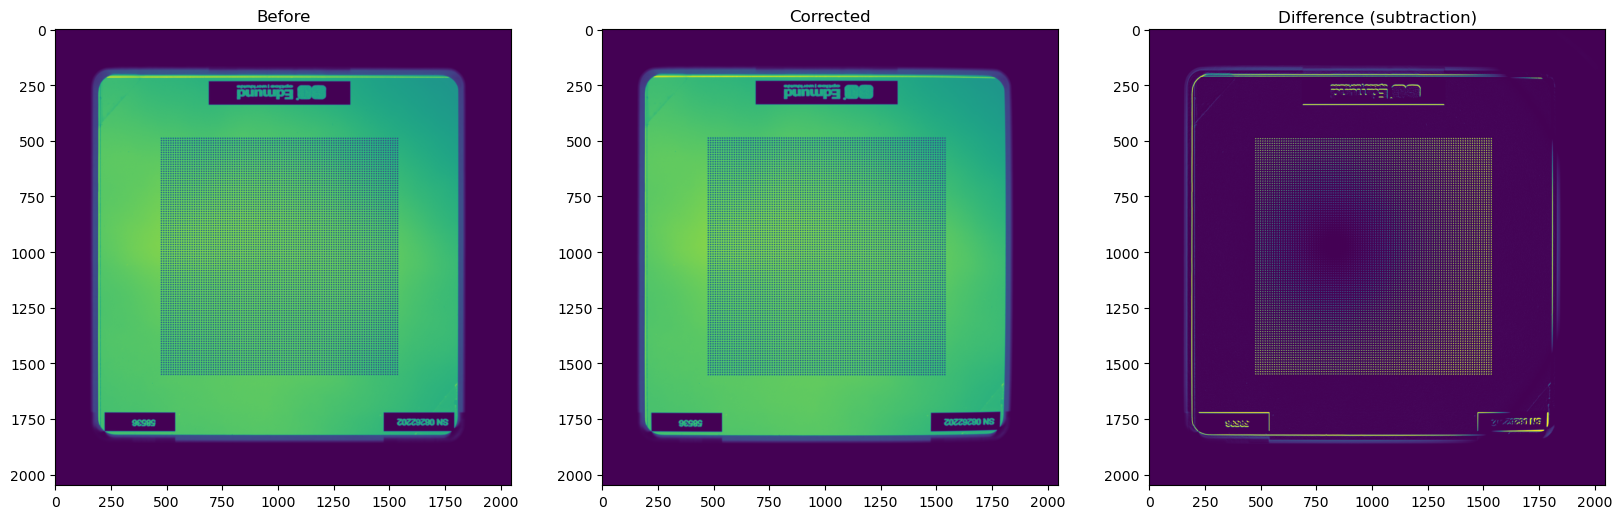

In [39]:
# Load coefficients from previous calculation if need to
# (xcenter, ycenter, list_fact) = losa.load_metadata_txt(
#     output_base + "/coefficients_radial_distortion.txt")
# Correct the image
corrected_mat = post.unwarp_image_backward(mat_crop, xcenter, ycenter, list_fact)
# f, ax = plt.subplots(2, 2, figsize=(20, 16))
# ax[0][0].imshow(mat_crop)#, vmax=0.2, vmin=0)
# ax[0][0].set_title('Before')
# ax[0][1].imshow(corrected_mat)#, vmax=0.2, vmin=0)
# ax[0][1].set_title('Corrected')
# ax[1][0].imshow(corrected_mat/mat_crop, vmax=1.2, vmin=0)
# ax[1][0].set_title('Difference (division)')
# ax[1][1].imshow(corrected_mat-mat_crop, )#vmax=1.2, vmin=0)
# ax[1][1].set_title('Difference (subtraction)')

f, ax = plt.subplots(1, 3, figsize=(20, 16))
ax[0].imshow(mat_crop)#, vmax=0.2, vmin=0)
ax[0].set_title('Before')
ax[1].imshow(corrected_mat)#, vmax=0.2, vmin=0)
ax[1].set_title('Corrected')
ax[2].imshow(corrected_mat-mat_crop, vmax=10000, vmin=0)
ax[2].set_title('Difference (subtraction)')
# ax[3].imshow(corrected_mat/mat_crop, vmax=1.2, vmin=0)
# ax[3].set_title('Difference (division)')

# Export HDF5

In [17]:
output_hdf5_dir = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '_BH_corr.h5'
print(output_hdf5)

/HFIR/CG1D/IPTS-32328/shared/autoreduce/hdf5/2024_03_11_3D_stage2_424proj_gridrec_BH_corrected_BH_corr.h5


In [18]:
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/recon_volume_BH', data=recon)
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))